# Perform repetitive sums benchmark using HF Inference endpoints on a variety of models

Actually, we could only test model `"meta-llama/Meta-Llama-3-8B-Instruct"` because we were rate limited.  

We might add more to the benchmark when the limit is waived.  

## install libs

In [16]:
!pip install git+https://github.com/huggingface/transformers #install from source to get latest version
!pip install datasets

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-1st71z5c
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-1st71z5c
  Resolved https://github.com/huggingface/transformers to commit a2ede66674d919fe507cc27db191f3314fd29948
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## load dataset

In [17]:
from datasets import load_dataset

dataset_ds = load_dataset('the-french-artist/repetitive_sums_benchmark', split='train')
dataset_ds

Dataset({
    features: ['sum', 'result'],
    num_rows: 99
})

In [18]:
additions_df = dataset_ds.to_pandas()
additions_df.head()

,sum,result
0,1+1,2
1,1+1+1,3
2,1+1+1+1,4
3,1+1+1+1+1,5
4,1+1+1+1+1+1,6


## define inference functions

### small example  

We do not have access to large models (more than 10GB).  
We do not have access to tool calling (as it is limited to 2 large models).  

Thus, we restrict output to a single token and will measure the response.  

In [19]:
from huggingface_hub import login, InferenceClient
from google.colab import userdata

login(userdata.get('HF_TOKEN'))

client = InferenceClient(model="meta-llama/Meta-Llama-3-8B-Instruct")
response = client.text_generation('What is the result of the sum 50+50 ? The result is : ', max_new_tokens=1)
print()
print('What is the result of the sum 50+50 ? The result is : ' + response)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful

What is the result of the sum 50+50 ? The result is : 100


### whole lot of needed functions for concurrent calls and benchmark analysis

In [20]:
from functools import partial
import concurrent.futures
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def get_sum_result(sum, curr_model):
  client = InferenceClient(model=curr_model)
  response = client.text_generation(f'What is the result of the sum {sum} ? The result is : ', max_new_tokens=1)
  return int(response)


def perform_parallel_sums(sums_to_compute, model_name):
    # Number of parallel calls
    N = 4

    # Create a partial function with model_name argument
    partial_get_sum_result = partial(get_sum_result, curr_model=model_name)

    # Create a ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor(max_workers=N) as executor:
        # Wrap the executor.map with tqdm for progress bar
        inferred_sums = list(tqdm(executor.map(partial_get_sum_result, sums_to_compute), total=len(sums_to_compute)))

    return inferred_sums

def get_benchmark_df(df, models_to_test, number_of_samples=10):

  inferred_sums = []
  for curr_model in tqdm(models_to_test, desc='inferring on models'):
      inferred_sums.append(perform_parallel_sums(df['sum'].tolist()[:number_of_samples], curr_model))

  df_list = []
  df_list.append(df.head(number_of_samples))

  for inference_results, model_name in zip(inferred_sums, models_to_test):
    df_list.append(pd.DataFrame(inference_results, columns=[model_name]))
  return pd.concat(df_list, axis=1)

def analyze_model(df, model_name):
  df = df.copy(deep=True)

  # count parsing failures
  number_of_parsing_failures = len(df[df[model_name] == 0])

  # compute accuracy including JSON parse errors as bad answers
  df['is_correct'] = df['result'].astype(int) == df[model_name]
  mean_accuracy = df.is_correct.mean()*100

  # exclude parsing failures from stat count as "0" is not a significant result to measure
  df = df[df[model_name] != 0]

  # select the failed results to compute error stats
  wrong_answers = df[df.is_correct == False].copy(deep=True)


  if len(wrong_answers) == 0:
    return {
        'model_name' : model_name,
        'avg_accuracy' : mean_accuracy,
        'error_mean' : 0,
        'error_median' : 0,
        'error_std' : 0,
        'error_min' : 0,
        'error_max' : 0,
        'parsing_failure_count' : number_of_parsing_failures
    }
  else:
    wrong_answers['error_abs'] = abs(wrong_answers['result'].astype(int) - wrong_answers[model_name])
    wrong_answers['error_prop'] = wrong_answers['error_abs'] / wrong_answers['result'].astype(int)
    return {
        'model_name' : model_name,
        'avg_accuracy' : mean_accuracy,
        'error_mean' : wrong_answers['error_abs'].mean(),
        'error_median' : wrong_answers['error_abs'].median(),
        'error_std' : wrong_answers['error_abs'].std(),
        'error_min' : wrong_answers['error_abs'].min(),
        'error_max' : wrong_answers['error_abs'].max(),
        'parsing_failure_count' : number_of_parsing_failures
    }

def get_stats_recap(benchmark_df, models_to_test):
  results = []
  for model_name in models_to_test:
    results.append(analyze_model(benchmark_df, model_name))

  return pd.DataFrame(results)

def show_model_results(df, model_name):
  df['is_correct'] = df['result'].astype(int) == df[model_name]

  sns.set_theme(style="whitegrid")

  # Order the results
  results = df['result'].astype(int).unique()
  results.sort()

  # set the high and width
  plt.figure(figsize=(20, 2))

  # Create the barplot
  g = sns.barplot(x="result", y=[1]*len(df), data=df, order=results, hue="is_correct", palette={False:"#EA5455", True:"#34A853"})

  # pivot label
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")

  # Add title and labels
  plt.title(f"Model : {model_name} - Position of correct sums")
  plt.xlabel("Sum")
  plt.show()


## Run inference on complete benchmark dataset

In [21]:
models_to_test = [
  "meta-llama/Meta-Llama-3-8B-Instruct"
]

number_of_samples = 100

benchmark_df = get_benchmark_df(additions_df, models_to_test, number_of_samples)
benchmark_df.head()

inferring on models:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

,sum,result,meta-llama/Meta-Llama-3-8B-Instruct
0,1+1,2,2
1,1+1+1,3,3
2,1+1+1+1,4,4
3,1+1+1+1+1,5,5
4,1+1+1+1+1+1,6,6


## Analyze results

In [22]:
get_stats_recap(benchmark_df, models_to_test)

,model_name,avg_accuracy,error_mean,error_median,error_std,error_min,error_max,parsing_failure_count
0,meta-llama/Meta-Llama-3-8B-Instruct,17.171717,29.817073,28.5,21.966376,1,69,0


<ipython-input-20-c5cb500647e8>:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


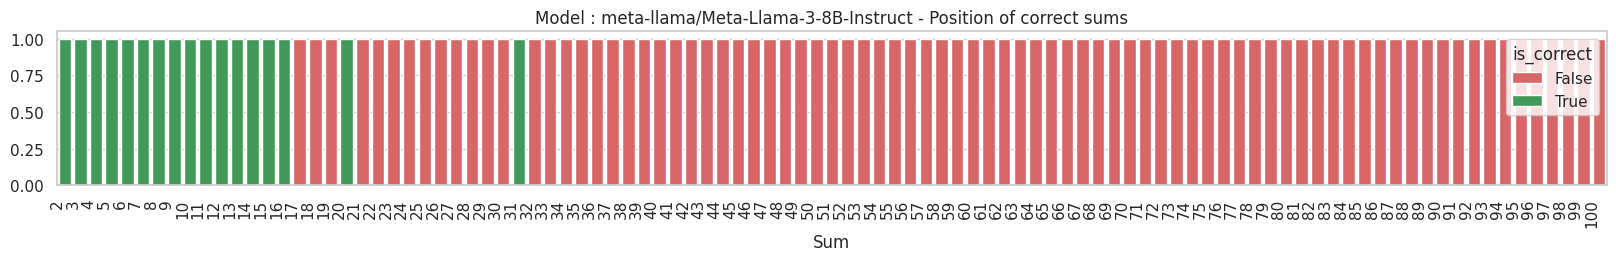

In [23]:
for curr_model in models_to_test:
  show_model_results(benchmark_df, curr_model)

## Test single models to compare the benchmark scores  

Sadly, we are rate limited.  
This marks the end of this test.  

In [29]:
# test single models

curr_model = "Qwen/Qwen2-7B-Instruct"
curr_model = "unsloth/llama-3-8b-bnb-4bit"
curr_model = "unsloth/mistral-7b-bnb-4bit"
curr_model = "meta-llama/Meta-Llama-3-8B-Instruct"

get_sum_result('1+1', curr_model)

HfHubHTTPError: 429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/meta-llama/Meta-Llama-3-8B-Instruct (Request ID: MEOqM9KZ8zQ0nYhG1ZR6c)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate